# Fashion-MNIST: CNN Style
Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of the network.

## Data preprocessing

In [16]:
import torch
import numpy as np

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [62]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 64
# Percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# choose the training and test datasets
train_data = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# create validation and train splits and prepare dataloaders
train_set, val_set = torch.utils.data.random_split(train_data, [int(len(train_data)*(1-valid_size)), int(len(train_data)*valid_size)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

48000

In [18]:
# Helper functions
import matplotlib.pyplot as plt
import numpy as np
def imshow(image):
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    
def imshow_np(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

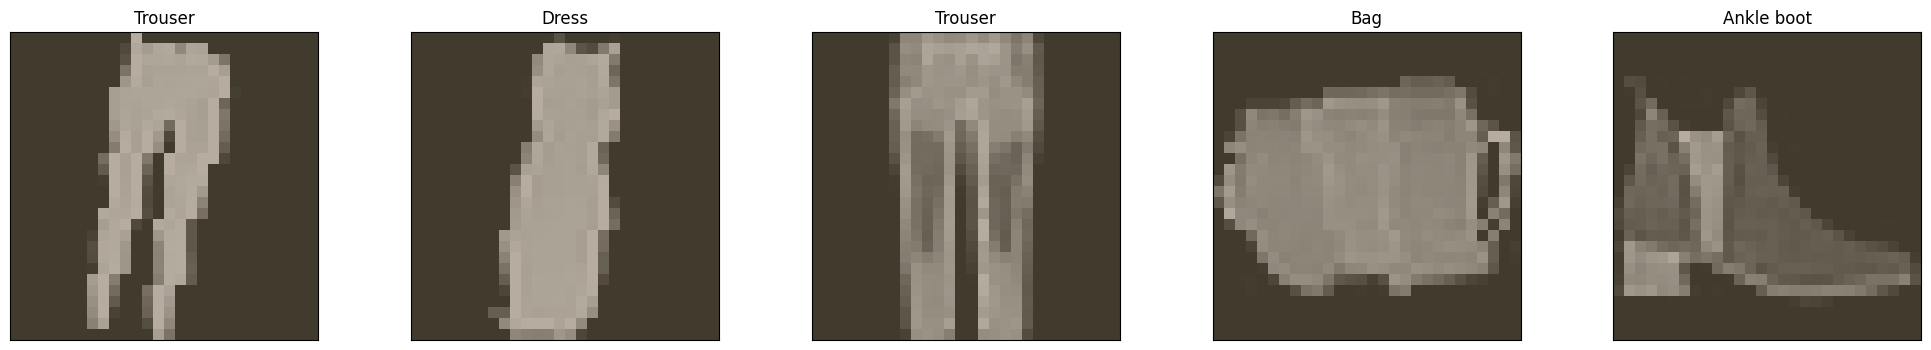

In [61]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 5 images
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Network Architecture

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [21]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

44426


# Training Phase

In [41]:
def train (dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        if train_on_gpu:
            X, y=X.cuda(), y.cuda()
        
        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')

In [45]:
def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            if train_on_gpu:
                X,y = X.cuda() ,y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    return test_loss

def evaluate_verbose(data_loader, model, loss_fn):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.eval()
    # iterate over test data
    for batch_idx, (data, target) in enumerate(data_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = loss_fn(output, target)
        # update test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(data_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    return test_loss

In [48]:
import torch.optim as optim

# Specify training parameters, model, loss function and optimizer
EPOCHS = 30
model = GarmentClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for i in range(EPOCHS):
    print(f"Epoch {i+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    avg_loss = evaluate(valid_loader, model, loss_fn)
    if i == 0 or avg_loss < min_loss:
        min_loss = avg_loss
        print('Validation loss has decreased, saving model as fashion_cnn_epoch_%d' % (i+1))
        torch.save(model.state_dict(), 'fashion_cnn_epoch_%d.pt' % (i+1))
print("Done!")

Epoch 1
-------------------------------
loss:2.313564 [    0/48000]
loss:2.293667 [ 6400/48000]
loss:2.308867 [12800/48000]
loss:2.284951 [19200/48000]
loss:2.282306 [25600/48000]
loss:2.267780 [32000/48000]
loss:2.229424 [38400/48000]
loss:2.110158 [44800/48000]
Test Error: 
 Accuracy: 35.4%, Avg loss: 1.994870 

Validation loss has decreased, saving model as fashion_cnn_epoch_1
Epoch 2
-------------------------------
loss:1.886082 [    0/48000]
loss:1.689010 [ 6400/48000]
loss:1.294654 [12800/48000]
loss:1.137479 [19200/48000]
loss:1.169011 [25600/48000]
loss:0.996689 [32000/48000]
loss:0.843230 [38400/48000]
loss:0.742952 [44800/48000]
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.849832 

Validation loss has decreased, saving model as fashion_cnn_epoch_2
Epoch 3
-------------------------------
loss:0.800614 [    0/48000]
loss:1.043200 [ 6400/48000]
loss:0.672697 [12800/48000]
loss:0.730819 [19200/48000]
loss:0.918455 [25600/48000]
loss:0.731629 [32000/48000]
loss:0.728309 [38400/48000

# Test the Network
We compare to different training states of our CNN

In [106]:
model.load_state_dict(torch.load('fashion_cnn_29.pt'))
_ = evaluate_verbose(test_loader, model, loss_fn)

Test Loss: 0.381371

Test Accuracy of T-shirt/top: 77% (774/1000)
Test Accuracy of Trouser: 96% (969/1000)
Test Accuracy of Pullover: 78% (785/1000)
Test Accuracy of Dress: 91% (912/1000)
Test Accuracy of  Coat: 67% (678/1000)
Test Accuracy of Sandal: 94% (945/1000)
Test Accuracy of Shirt: 70% (708/1000)
Test Accuracy of Sneaker: 93% (938/1000)
Test Accuracy of   Bag: 96% (961/1000)
Test Accuracy of Ankle Boot: 91% (919/1000)

Test Accuracy (Overall): 85% (8589/10000)


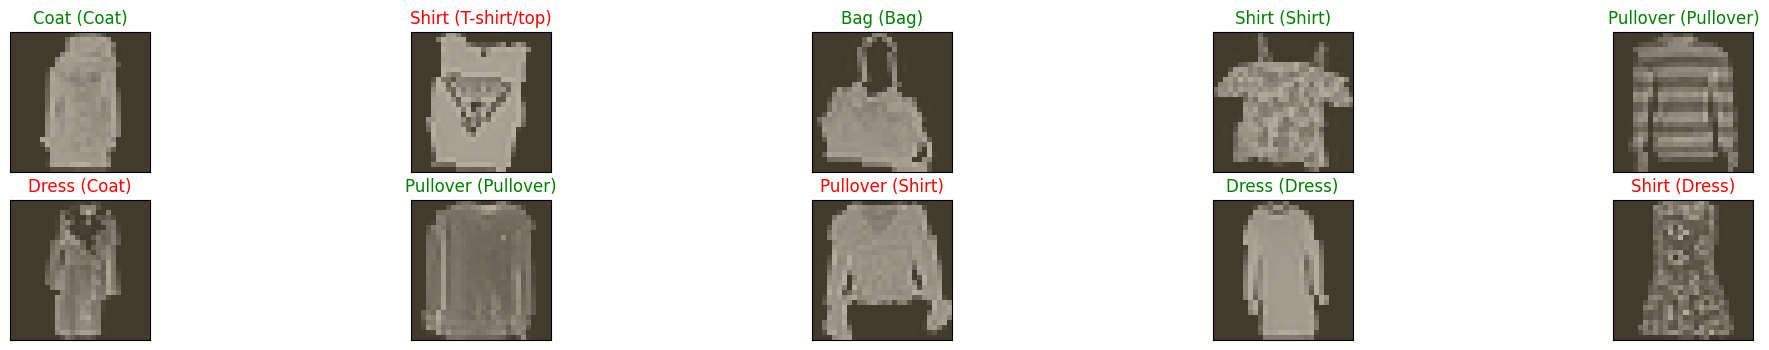

In [107]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot some images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow_np(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Confusion Matrix

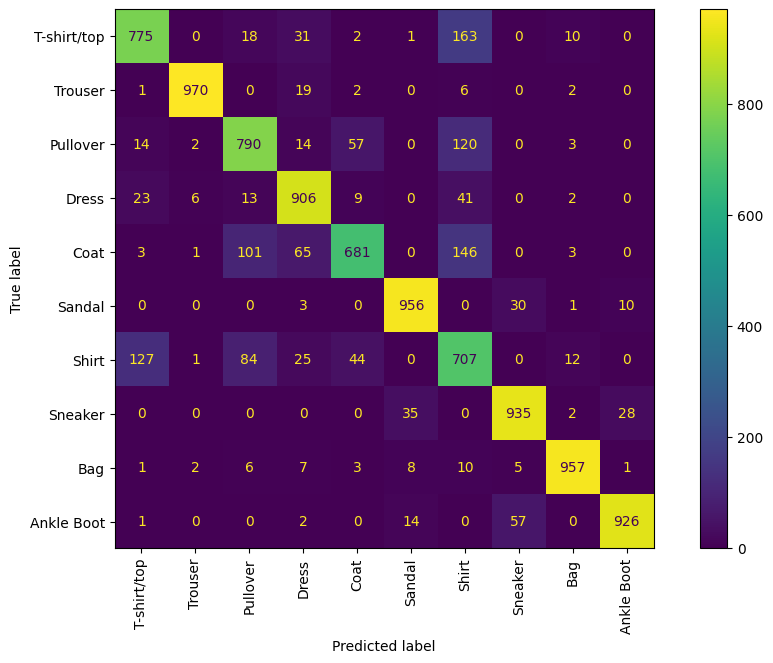

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Iterate over test data
y_pred = []
y_true = []

for inputs, labels in test_loader:
    
        if torch.cuda.is_available():
            output = model(inputs.cuda()) # Feed Network
        else:
            output = model(inputs.cpu()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        

# Build confusion matrix
fig, ax = plt.subplots(figsize = (12,7))
ConfusionMatrixDisplay.from_predictions(
     y_true, 
     y_pred, 
     display_labels=classes,
     xticks_rotation='vertical',
     ax=ax
)

plt.savefig('output_29_epochs.png')
